In [13]:
import h5py
import sys
import matplotlib.pyplot as plt
import numpy as np
import fenics as fe
import pandas as pd

sys.path.insert(0, "../scripts/")

from glob import glob
from mpi4py import MPI
from swe_2d import ShallowTwo

In [14]:
mesh_file = "../mesh/swe-square-cylinder-test-refined.xdmf"
output_file = "../outputs/swe-lyn-rodi-refined.h5"

# outputs = h5py.File(output_file, mode="r")
outputs = fe.HDF5File(MPI.COMM_WORLD, output_file, "r")

In [15]:
simulation = "cylinder"
control = {"dt": 1e-3,
           "theta": 0.6,
           "simulation": simulation,
           "laplacian": True,
           "les": False,
           "integrate_continuity_by_parts": True}

swe = ShallowTwo(mesh=mesh_file, control=control)
outputs.read(swe.du, "/du/vector_666")

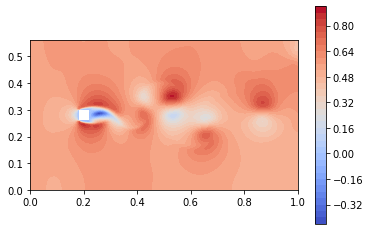

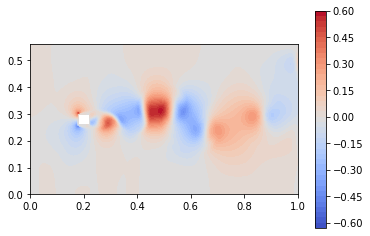

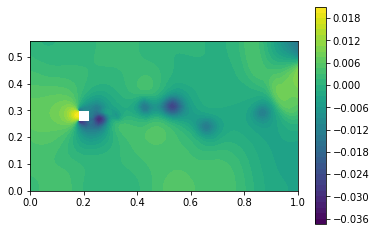

In [19]:
u, h = swe.du.split()
im = fe.plot(u.sub(0), cmap="coolwarm")
plt.colorbar(im)
plt.show()

im = fe.plot(u.sub(1), cmap="coolwarm")
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

In [6]:
u([0.24, 0.28])

array([-0.43760658, -0.00301536])

In [7]:
data_files = glob("../data/lyn-rodi-verification/phase_av/t_*.dat")

dataframes = []
for data_file in data_files:
    dataframes.append(
        pd.read_csv(data_file, skiprows=7, sep="\s+",
                    names=["x/H", "y/H", "Umean/U", "Vmean/U", "u'/U", "v'/U", "u'v'/U^2", "fff_u", "fff_v"]))

dat = pd.concat(dataframes)
dat

,x/H,y/H,Umean/U,Vmean/U,u'/U,v'/U,u'v'/U^2,fff_u,fff_v
0,2.0,0.000,0.348,-0.050,0.344,0.879,0.006780,0.84,0.47
1,2.0,0.125,0.378,-0.086,0.346,0.864,-0.040200,0.86,0.45
2,2.0,0.250,0.407,-0.110,0.370,0.828,-0.090500,0.86,0.43
3,2.0,0.375,0.464,-0.136,0.389,0.779,-0.118000,0.87,0.41
4,2.0,0.500,0.536,-0.155,0.396,0.708,-0.126000,0.89,0.38
...,...,...,...,...,...,...,...,...,...
4,0.0,1.125,1.333,0.211,0.084,0.090,-0.004260,1.00,1.00
5,0.0,1.250,1.293,0.179,0.071,0.082,-0.003190,1.00,0.99
6,0.0,1.500,1.234,0.135,0.054,0.071,-0.001640,1.00,0.98
7,0.0,1.750,1.194,0.099,0.045,0.060,-0.000894,1.00,0.96


[0.875 1.    1.125 1.25  1.375 1.5   1.625 1.75  1.875 2.    2.125 2.25
 2.375 2.5   2.625 2.75  2.875 3.    3.25  3.5   3.75  4.    4.25  4.5
 4.75  5.    5.25  5.5   5.75  6.    6.4   6.8   7.2   7.6   8.   ]


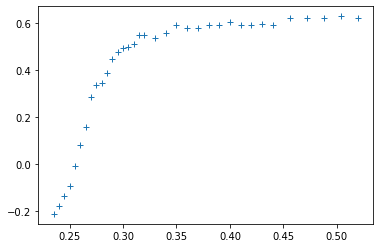

In [8]:
dat_centre_slice = dat[np.isclose(dat["y/H"], 0.)]
x_obs = 5 * 0.04 + dat_centre_slice["x/H"] * 0.04
plt.plot(x_obs, dat_centre_slice["Umean/U"], "+")
print(np.unique(dat_centre_slice["x/H"]))

In [9]:
nt = 1000
nx_obs = 100
x_model_interp = np.array([[x, 7 * 0.04] for x in np.linspace(6 * 0.04, 1, num=nx_obs)])

u_obs = np.zeros((nt, nx_obs))
for i in range(nt):
    outputs.read(swe.du, f"/du/vector_{i:d}")
    u, h = swe.du.split()
    for j, x in enumerate(x_model_interp):
        u_obs[i, j] = u(x)[0]
        
outputs.close()

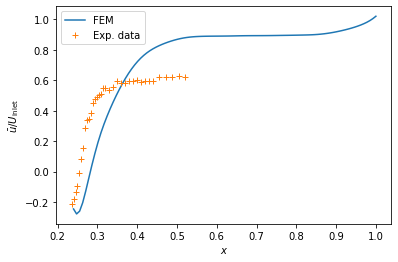

In [10]:
plt.plot(x_model_interp[:, 0], np.mean(u_obs / 0.535, axis=0), label="FEM")
plt.plot(x_obs, dat_centre_slice["Umean/U"], "+", label="Exp. data")
plt.xlabel(r"$x$")
plt.ylabel(r"$\bar{u} / U_{\mathrm{inlet}}$")
plt.legend()
plt.show()

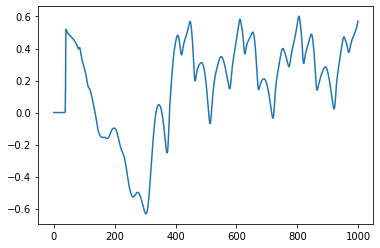

In [11]:
idx = np.argmin(np.abs(x_model_interp[:, 0] - 0.3))

plt.plot(u_obs[:, 10])
plt.show()